<a href="https://colab.research.google.com/github/kuds/rl-mujoco-tennis/blob/main/%5BMuJoCo%20Humanoid%5D%20Proximal%20Policy%20Optimization%20(PPO).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title
!pip install mujoco

# Set up GPU rendering.
from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [2]:
!pip install stable-baselines3

In [3]:
import gymnasium
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import VecVideoRecorder
from stable_baselines3.common.env_util import make_vec_env
import numpy
import os
import torch
import platform
from importlib.metadata import version
import matplotlib
import matplotlib.pyplot

In [4]:
print(f"Python Version: {platform.python_version()}")
print(f"Torch Version: {version('torch')}")
print(f"Is Cuda Available: {torch.cuda.is_available()}")
print(f"Cuda Version: {torch.version.cuda}")
print(f"Gymnasium Version: {version('gymnasium')}")
print(f"Numpy Version: {version('numpy')}")
print(f"MuJoCo Version: {version('mujoco')}")
print(f"Stable Baselines3 Version: {version('stable_baselines3')}")

Python Version: 3.11.11
Torch Version: 2.5.1+cu124
Is Cuda Available: True
Cuda Version: 12.4
Gymnasium Version: 1.0.0
Numpy Version: 1.26.4
MuJoCo Version: 3.3.0
Stable Baselines3 Version: 2.5.0


In [5]:
rl_type = "PPO"
env_str = "Humanoid-v5"
log_dir = "./logs/{}".format(env_str)
name_prefix = "humanoid"

In [6]:
# Create Training environment
env = make_vec_env(env_str, n_envs=4)

# Create Evaluation environment
env_val = make_vec_env(env_str, n_envs=1)

eval_callback = EvalCallback(env_val,
                             best_model_save_path=log_dir,
                             log_path=log_dir,
                             render=False,
                             deterministic=True,
                             eval_freq=50_000)

# Create the PPO model
model = PPO(
    policy="MlpPolicy",  # Multi-layer perceptron policy
    env=env,
    verbose=0,
    learning_rate=0.0003,
    ent_coef=0.01,
    tensorboard_log=log_dir
)

# Train the model
time_steps = 5_000_000
model.learn(total_timesteps=time_steps,
            callback=eval_callback,
            progress_bar=True)

# Save the model
model.save(os.path.join(log_dir, "final_model"))

mean_reward, std_reward = evaluate_policy(model, env)
print(f"Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

Output()

/usr/local/lib/python3.11/dist-packages/ipywidgets/widgets/widget_output.py:111: DeprecationWarning: 
Kernel._parent_header is deprecated in ipykernel 6. Use .get_parent()
  if ip and hasattr(ip, 'kernel') and hasattr(ip.kernel, '_parent_header'):

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Eval num_timesteps=100000, episode_reward=265.43 +/- 8.93

Episode length: 49.80 +/- 1.72

New best mean reward!

Eval num_timesteps=200000, episode_reward=267.18 +/- 12.69

Episode length: 50.60 +/- 2.24

New best mean reward!

Eval num_timesteps=300000, episode_reward=265.63 +/- 2.01

Episode length: 50.20 +/- 0.40

Eval num_timesteps=400000, episode_reward=276.91 +/- 9.27

Episode length: 52.20 +/- 1.72

New best mean reward!

Eval num_timesteps=500000, episode_reward=295.02 +/- 17.32

Episode length: 57.00 +/- 3.29

New best mean reward!

Eval num_timesteps=600000, episode_reward=325.88 +/- 16.17

Episode length: 62.40 +/- 3.01

New best mean reward!

Eval num_timesteps=700000, episode_reward=410.66 +/- 29.81

Episode length: 81.80 +/- 6.94

New best mean reward!

Eval num_timesteps=800000, episode_reward=353.20 +/- 29.01

Episode length: 67.60 +/- 5.04

Eval num_timesteps=900000, episode_reward=386.65 +/- 30.12

Episode length: 75.20 +/- 5.11

Eval num_timesteps=1000000, episode_reward=323.90 +/- 29.66

Episode length: 65.00 +/- 5.22

Eval num_timesteps=1100000, episode_reward=334.40 +/- 11.59

Episode length: 66.80 +/- 2.32

Eval num_timesteps=1200000, episode_reward=430.22 +/- 51.00

Episode length: 88.60 +/- 13.29

New best mean reward!

Eval num_timesteps=1300000, episode_reward=396.83 +/- 20.56

Episode length: 79.00 +/- 5.62

Eval num_timesteps=1400000, episode_reward=516.56 +/- 98.33

Episode length: 106.80 +/- 15.48

New best mean reward!

Eval num_timesteps=1500000, episode_reward=459.13 +/- 122.86

Episode length: 98.80 +/- 23.11

Eval num_timesteps=1600000, episode_reward=387.97 +/- 60.41

Episode length: 81.60 +/- 11.27

Eval num_timesteps=1700000, episode_reward=447.34 +/- 46.20

Episode length: 88.40 +/- 9.09

Eval num_timesteps=1800000, episode_reward=388.92 +/- 28.28

Episode length: 78.80 +/- 5.49

Eval num_timesteps=1900000, episode_reward=491.20 +/- 130.91

Episode length: 108.40 +/- 31.20

Eval num_timesteps=2000000, episode_reward=585.35 +/- 87.47

Episode length: 122.20 +/- 21.54

New best mean reward!

Eval num_timesteps=2100000, episode_reward=539.33 +/- 126.80

Episode length: 112.20 +/- 21.98

Eval num_timesteps=2200000, episode_reward=418.27 +/- 72.15

Episode length: 82.40 +/- 14.40

Eval num_timesteps=2300000, episode_reward=382.93 +/- 53.40

Episode length: 81.80 +/- 12.37

Eval num_timesteps=2400000, episode_reward=408.25 +/- 134.17

Episode length: 84.60 +/- 26.11

Eval num_timesteps=2500000, episode_reward=421.02 +/- 57.83

Episode length: 90.60 +/- 12.82

Eval num_timesteps=2600000, episode_reward=524.89 +/- 128.10

Episode length: 104.00 +/- 22.38

Eval num_timesteps=2700000, episode_reward=606.68 +/- 101.63

Episode length: 124.40 +/- 28.49

New best mean reward!

Eval num_timesteps=2800000, episode_reward=519.18 +/- 90.59

Episode length: 103.00 +/- 16.38

Eval num_timesteps=2900000, episode_reward=600.98 +/- 82.25

Episode length: 117.20 +/- 16.92

Eval num_timesteps=3000000, episode_reward=537.57 +/- 42.13

Episode length: 112.00 +/- 10.18

Eval num_timesteps=3100000, episode_reward=546.38 +/- 119.25

Episode length: 114.20 +/- 27.97

Eval num_timesteps=3200000, episode_reward=585.36 +/- 101.45

Episode length: 120.20 +/- 19.28

Eval num_timesteps=3300000, episode_reward=518.54 +/- 114.28

Episode length: 109.20 +/- 21.57

Eval num_timesteps=3400000, episode_reward=383.59 +/- 43.07

Episode length: 79.80 +/- 9.62

Eval num_timesteps=3500000, episode_reward=282.76 +/- 14.52

Episode length: 60.80 +/- 2.32

Eval num_timesteps=3600000, episode_reward=314.19 +/- 60.91

Episode length: 69.00 +/- 14.38

Eval num_timesteps=3700000, episode_reward=292.43 +/- 32.02

Episode length: 61.80 +/- 6.55

Eval num_timesteps=3800000, episode_reward=309.27 +/- 11.51

Episode length: 65.40 +/- 2.65

Eval num_timesteps=3900000, episode_reward=300.39 +/- 48.49

Episode length: 63.60 +/- 11.25

Eval num_timesteps=4000000, episode_reward=319.89 +/- 86.12

Episode length: 69.60 +/- 19.73

Eval num_timesteps=4100000, episode_reward=300.28 +/- 29.92

Episode length: 64.60 +/- 7.55

Eval num_timesteps=4200000, episode_reward=296.18 +/- 27.29

Episode length: 62.80 +/- 5.11

Eval num_timesteps=4300000, episode_reward=442.34 +/- 76.14

Episode length: 87.60 +/- 14.55

Eval num_timesteps=4400000, episode_reward=383.41 +/- 31.66

Episode length: 79.60 +/- 6.71

Eval num_timesteps=4500000, episode_reward=376.64 +/- 36.65

Episode length: 80.00 +/- 7.56

Eval num_timesteps=4600000, episode_reward=580.02 +/- 145.41

Episode length: 119.40 +/- 32.05

Eval num_timesteps=4700000, episode_reward=289.85 +/- 13.85

Episode length: 61.20 +/- 2.79

Eval num_timesteps=4800000, episode_reward=336.56 +/- 32.98

Episode length: 73.80 +/- 7.86

Eval num_timesteps=4900000, episode_reward=412.47 +/- 23.58

Episode length: 88.40 +/- 4.76

Eval num_timesteps=5000000, episode_reward=470.42 +/- 118.08

Episode length: 99.20 +/- 21.38

Mean reward: 397.29 +/- 73.06


In [7]:
# Create Evaluation environment
env = make_vec_env(env_str, n_envs=1, seed=0)

# Load the best model
best_model_path = os.path.join(log_dir, "best_model.zip")
best_model = PPO.load(best_model_path, env=env)

mean_reward, std_reward = evaluate_policy(best_model, env)
print(f"Best Model - Mean reward: {mean_reward:.2f} +/- {std_reward:.2f}")

# Record video of the best model
env = VecVideoRecorder(env, os.path.join(log_dir, "videos"),
                       video_length=10_000,
                       record_video_trigger=lambda x: x == 0,
                       name_prefix="best_model_{}".format(name_prefix))

obs = env.reset()
for _ in range(10_000):
    action, _states = best_model.predict(obs, deterministic=True)
    obs, rewards, dones, info = env.step(action)
    env.render()
    if dones:
        break

env.close()

Best Model - Mean reward: 557.89 +/- 64.50


/usr/local/lib/python3.11/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


Moviepy - Building video /content/videos/best_model_humanoid-step-0-to-step-10000.mp4.
Moviepy - Writing video /content/videos/best_model_humanoid-step-0-to-step-10000.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/best_model_humanoid-step-0-to-step-10000.mp4


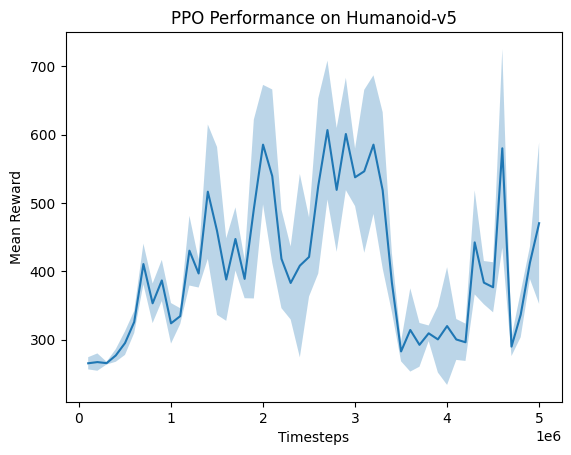

In [8]:
# Load the evaluations.npz file
data = numpy.load(os.path.join(log_dir, "evaluations.npz"))

# Extract the relevant data
timesteps = data['timesteps']
results = data['results']

# Calculate the mean and standard deviation of the results
mean_results = numpy.mean(results, axis=1)
std_results = numpy.std(results, axis=1)

# Plot the results
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(timesteps, mean_results)
matplotlib.pyplot.fill_between(timesteps,
                               mean_results - std_results,
                               mean_results + std_results,
                               alpha=0.3)

matplotlib.pyplot.xlabel('Timesteps')
matplotlib.pyplot.ylabel('Mean Reward')
matplotlib.pyplot.title(f"{rl_type} Performance on {env_str}")
matplotlib.pyplot.show()